<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Thedin-Bandara/sarima_jumper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#SAFRIMA
#Seasonal AutoRegressive Fractionally Integrated Moving Average

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller

In [3]:
# Specify the file path
!ls -l $file_path
file_path = 'preprocessed_data_new.xlsx'

data = pd.read_excel(file_path)

total 3812
-rw-r--r-- 1 root root 3896494 Mar  5 04:36 preprocessed_data_new.xlsx
drwxr-xr-x 1 root root    4096 Feb 29 14:23 sample_data


In [56]:
# Define a mapping of sub-departments to main departments
sub_dept_to_main_dept = {
    'Jumper Team': [sub_dept for sub_dept in data['Department'] if sub_dept.startswith('Jumper Team')]

}


# Map each sub-department to its main department
main_dept_for_sub_dept = {}
for main_dept, sub_depts in sub_dept_to_main_dept.items():
    for sub_dept in sub_depts:
        main_dept_for_sub_dept[sub_dept] = main_dept

# Add a new column indicating the main department for each row
data['MainDepartment'] = data['Department'].map(main_dept_for_sub_dept)


In [57]:
#main department all leaves
leave_days_by_month = data.groupby(['LeaveYear', 'LeaveMonth']).size().reset_index(name='TotalLeaveDays')
print(leave_days_by_month)

    LeaveYear  LeaveMonth  TotalLeaveDays
0        2021          12            3184
1        2022           1            2181
2        2022           2            2353
3        2022           3            2471
4        2022           4            1770
5        2022           5            3351
6        2022           6            2834
7        2022           7            1580
8        2022           8            1724
9        2022           9            1575
10       2022          10            1905
11       2022          11            1664
12       2022          12            1155
13       2023           1            1104
14       2023           2             412
15       2023           3            1264
16       2023           4             469
17       2023           5            1758
18       2023           6            1260
19       2023           7            1098
20       2023           8            1082
21       2023           9            1030
22       2023          10         

ADF Statistic: -0.9336382039217688
p-value: 0.7766931768801943
Critical Values:
   1%: -3.8092091249999998
   5%: -3.0216450000000004
   10%: -2.6507125


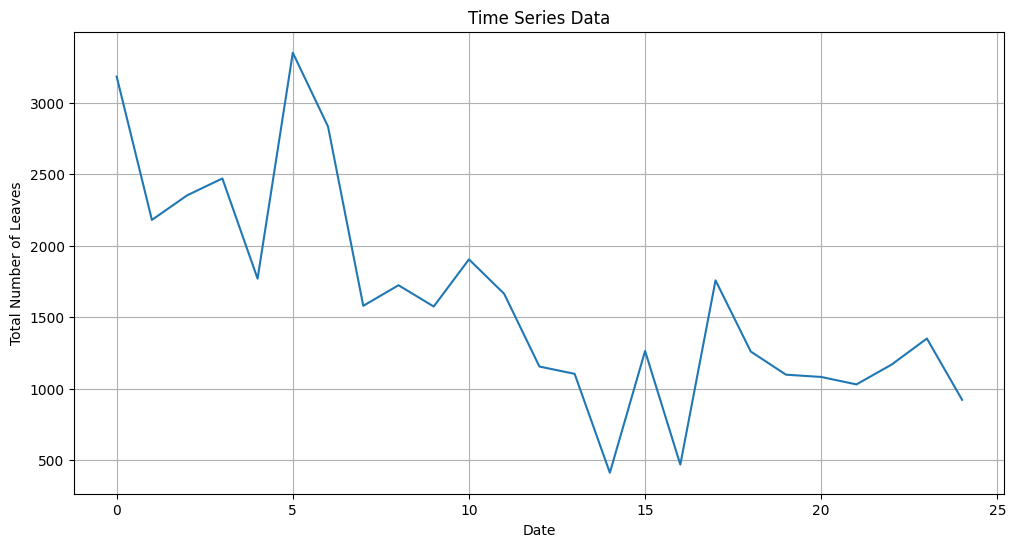

In [7]:
def adf_test(timeseries):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

adf_test(leave_days_by_month['TotalLeaveDays'])

# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(leave_days_by_month['TotalLeaveDays'])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Total Number of Leaves')
plt.grid(True)
plt.show()

In [43]:
# Step 3: Split Data
train_size = int(len(leave_days_by_month) * 0.9)
train_data, test_data = leave_days_by_month['TotalLeaveDays'][:train_size], leave_days_by_month['TotalLeaveDays'][train_size:]
# Step 4: Build and Train SARFIMA Model
order = (5, 2, 4)  # Example SARIMA parameters (p, d, q)
seasonal_order = (0, 0, 0, 12)  # Example seasonal parameters (P, D, Q, S)
sarima_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, trend='c', enforce_stationarity=False)
trained_model = sarima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


22     750.978857
23    1173.368089
24     580.998296
Name: predicted_mean, dtype: float64
Mean Squared Error: 107525.64465542132
Root Mean Squared Error (RMSE): 327.91103161592673


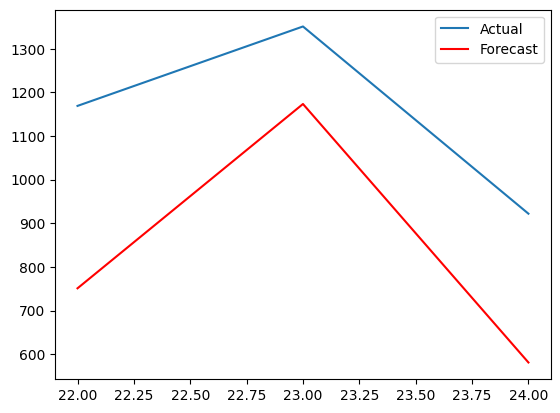

In [44]:
# Step 5: Validate Model
forecast = trained_model.forecast(steps=3)
print(forecast)
# Step 6: Evaluate Model
mse = mean_squared_error(test_data, forecast)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Visualize Results
plt.plot(test_data, label='Actual')
plt.plot(forecast, color='red', label='Forecast')
plt.legend()
plt.show()